# Question 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import imageio
import seaborn as sns

batch_size_train = 1024
batch_size_test = 10

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x : x*255)
])
# Define the loader for training data.
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('.', train=True, download=True,transform=transform),
  batch_size=batch_size_train, shuffle=True)

# Define the loader for testing data.
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('.', train=False, download=True, transform=transform),
  batch_size=batch_size_test, shuffle=False)

first_b = next(iter(test_loader))

print(np.min(first_b[0].numpy()))
print(np.max(first_b[0].numpy()))
print(np.mean(first_b[0].numpy()))

def KL_div_N01(z_mu, z_log_sigma_sq):
    term_1 = z_log_sigma_sq.sum(axis=1)
    term_2 = z_log_sigma_sq.exp().sum(axis=1)
    term_3 = (z_mu * z_mu).sum(axis=1)
    return 0.5 * (-term_1 + term_2 + term_3 - z_mu.shape[1]).mean()

##
## fully connected
##
class VAE( nn.Module ):
    def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
        super(VAE, self).__init__()

        self.enc = nn.ModuleList()
        self.dec = nn.ModuleList()
        self.n_z = n_z

        for i in range(n_layers+1):
            if i == 0: #first layers
                self.enc.append(nn.Linear(n_input, layer_size))
                self.dec.append(nn.Linear(n_z, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())
            elif i == n_layers: #last layers
                self.enc.append(nn.Linear(layer_size, 2*n_z)) # we need this for enc's mu and sigma
                self.dec.append(nn.Linear(layer_size, n_output))
            else:
                self.enc.append(nn.Linear(layer_size, layer_size))
                self.dec.append(nn.Linear(layer_size, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())

        self.enc = nn.Sequential(*self.enc)
        self.dec = nn.Sequential(*self.dec)
  
  
    def enc_to_mean_lss(self,x):
        enc_output = self.enc(x)
        mean = enc_output[...,:self.n_z]
        log_sigma_sq = enc_output[...,self.n_z:]
        return mean, log_sigma_sq

    def forward(self, x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)

        sigma = log_sigma_sq.exp().sqrt()
        z = mean + torch.randn_like(mean)*sigma
        output = self.dec(z)

        return output
  
    def forward_train(self, x):

        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
        output = self.dec(z)

        return output, mean, log_sigma_sq
  
    def encode_mean(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        return mean

    def encode(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        sigma = self.enc_log_sigma_sq.exp().sqrt()
        return mean + torch.randn_like(mean)*sigma

    def decode(self,z):
        return self.dec(z)

class ConditionalVAE(VAE):
    def __init__(self, n_input, n_output, n_z, n_layers, layer_size, n_condition):
        super(ConditionalVAE, self).__init__(n_input, n_output, n_z, n_layers, layer_size)
        
        self.n_condition = n_condition
        self.label_embedding = nn.Embedding(n_condition, n_condition)

        # Modify enc and dec to accept condition
        self.enc[0] = nn.Linear(n_input + n_condition, layer_size)
        self.dec[0] = nn.Linear(n_z + n_condition, layer_size)
    
    def forward_train(self, x, condition):
        condition = self.label_embedding(condition)
        
        x_conditioned = torch.cat([x, condition], dim=1)
        mean, log_sigma_sq = self.enc_to_mean_lss(x_conditioned)

        
        z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
        
        z_conditioned = torch.cat([z, condition], dim=1)
        output = self.dec(z_conditioned)
        
        return output, mean, log_sigma_sq

0.0
255.0
29.54222


In [2]:
performance_metrics_vae = {'loss': [], 'kl_loss': [], 'mse_loss': []}
performance_metrics_cvae = {'loss': [], 'kl_loss': [], 'mse_loss': []}
## network params
input_size = 28**2
n_z = 2
n_layers = 3
layer_size = 512

saved_params_path="saved_params"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

## training params
n_epochs = 100

In [3]:
vae_instance = VAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size)
optimizer = torch.optim.Adam(vae_instance.parameters(), lr=3e-4)
mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01

cvae_instance = ConditionalVAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size, n_condition=10)
optimizer_cvae = torch.optim.Adam(cvae_instance.parameters(), lr=3e-4)

In [4]:


vae_instance = VAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size)

# Define the loss function.
mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01

# Define the optimizer.
optimizer = torch.optim.Adam(vae_instance.parameters(), lr=3e-4)

print(vae_instance)
for epoch in range(n_epochs):

    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0
    
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        
        images_in = inputs.view(inputs.shape[0], -1).clone().detach()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_hat, mean, log_sigma_sq  = vae_instance.forward_train(images_in)
        
        mse_loss = mse_loss_func(x_hat, images_in)
        kl_div_loss = kl_loss_func(mean, log_sigma_sq)
        loss = mse_loss + kl_div_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_kl_loss += kl_div_loss.item()
        running_mse_loss += mse_loss.item()
        running_n += inputs.shape[0]

    print(
        f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
        f'KL loss: {running_kl_loss / running_n:.6f}',
        f'MSE loss: {running_mse_loss / running_n:.6f}')

    performance_metrics_vae['loss'].append(running_loss / running_n)
    performance_metrics_vae['kl_loss'].append(running_kl_loss / running_n)
    performance_metrics_vae['mse_loss'].append(running_mse_loss / running_n)

    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0
    
    torch.save(vae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(vae_instance.state_dict(), 'final_model.pth')
# Save the optimization states. This is helpful for continual training.
torch.save(optimizer.state_dict(), 'optimizer.pth')

print('Finished Training for VAE')



VAE(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=4, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)
[1,    59] loss: 5.110584 KL loss: 0.145635 MSE loss: 4.964950
[2,    59] loss: 4.081521 KL loss: 0.020726 MSE loss: 4.060795
[3,    59] loss: 4.073711 KL loss: 0.014392 MSE loss: 4.059319
[4,    59] loss: 4.057241 KL loss: 0.014581 MSE loss: 4.042660
[5,    59] loss: 3.738340 KL loss: 0.027681 MSE loss: 3.710659
[6,    59] loss: 3.548849 KL loss: 0.020

In [5]:
# Create Conditional VAE
cvae_instance = ConditionalVAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size, n_condition=10)
optimizer_cvae = torch.optim.Adam(cvae_instance.parameters(), lr=3e-4)

# Training loop for CVAE
for epoch in range(n_epochs):
    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        images_in = inputs.view(inputs.shape[0], -1).clone().detach()

        optimizer_cvae.zero_grad()

        x_hat, mean, log_sigma_sq = cvae_instance.forward_train(images_in, labels)
        
        mse_loss = mse_loss_func(x_hat, images_in)
        kl_div_loss = kl_loss_func(mean, log_sigma_sq)
        loss = mse_loss + kl_div_loss
        loss.backward()
        optimizer_cvae.step()

        running_loss += loss.item()
        running_kl_loss += kl_div_loss.item()
        running_mse_loss += mse_loss.item()
        running_n += inputs.shape[0]
        
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
          f'KL loss: {running_kl_loss / running_n:.6f}',
          f'MSE loss: {running_mse_loss / running_n:.6f}')
    
    performance_metrics_cvae['loss'].append(running_loss / running_n)
    performance_metrics_cvae['kl_loss'].append(running_kl_loss / running_n)
    performance_metrics_cvae['mse_loss'].append(running_mse_loss / running_n)
    
    torch.save(cvae_instance.state_dict(), f'{saved_params_path}/cvae_{epoch}.pth')

# Save the trained model
torch.save(cvae_instance.state_dict(), 'final_model_cvae.pth')
# Save the optimization states. This is helpful for continual training.
torch.save(optimizer_cvae.state_dict(), 'optimizer_cvae.pth')

[1,    59] loss: 5.445440 KL loss: 0.142093 MSE loss: 5.303347
[2,    59] loss: 4.082075 KL loss: 0.021380 MSE loss: 4.060695
[3,    59] loss: 4.065668 KL loss: 0.012555 MSE loss: 4.053113
[4,    59] loss: 3.995303 KL loss: 0.011178 MSE loss: 3.984126
[5,    59] loss: 3.736637 KL loss: 0.019296 MSE loss: 3.717341
[6,    59] loss: 3.551317 KL loss: 0.017741 MSE loss: 3.533576
[7,    59] loss: 3.359142 KL loss: 0.017899 MSE loss: 3.341242
[8,    59] loss: 3.199750 KL loss: 0.017409 MSE loss: 3.182341
[9,    59] loss: 3.067259 KL loss: 0.017554 MSE loss: 3.049705
[10,    59] loss: 2.944240 KL loss: 0.018344 MSE loss: 2.925896
[11,    59] loss: 2.868872 KL loss: 0.017525 MSE loss: 2.851346
[12,    59] loss: 2.812384 KL loss: 0.016744 MSE loss: 2.795639
[13,    59] loss: 2.764068 KL loss: 0.016457 MSE loss: 2.747611
[14,    59] loss: 2.721234 KL loss: 0.016682 MSE loss: 2.704551
[15,    59] loss: 2.661995 KL loss: 0.019081 MSE loss: 2.642913
[16,    59] loss: 2.606019 KL loss: 0.019053 MSE 

In [6]:
# load the trained model
vae_instance.load_state_dict(torch.load('final_model.pth'))
cvae_instance.load_state_dict(torch.load('final_model_cvae.pth'))

# load the optimization states
optimizer.load_state_dict(torch.load('optimizer.pth'))
optimizer_cvae.load_state_dict(torch.load('optimizer_cvae.pth'))

# Set the model to evaluation mode. This is important for layers like dropout, batchnorm etc which behave differently in training and evaluation mode.
vae_instance.eval()
cvae_instance.eval()

ConditionalVAE(
  (enc): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=4, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
  (label_embedding): Embedding(10, 10)
)

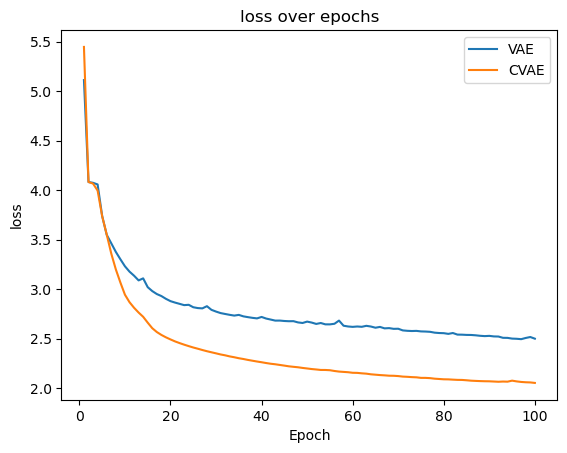

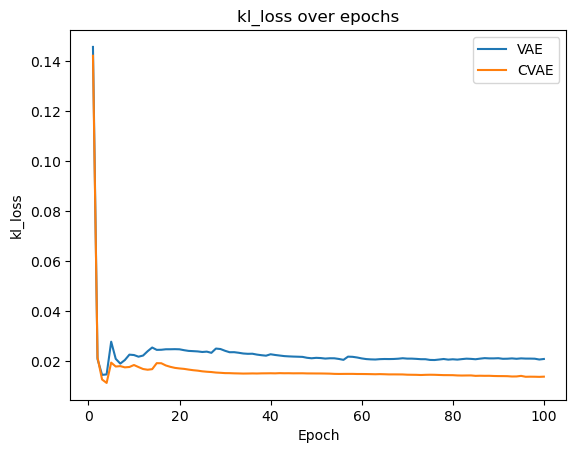

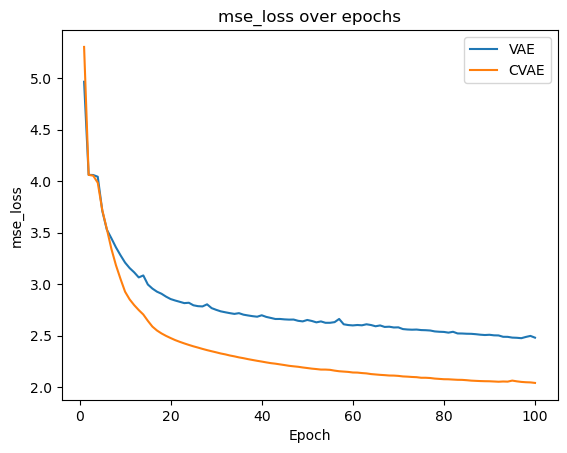

In [7]:
epochs = list(range(1, n_epochs + 1))
for metric in ['loss', 'kl_loss', 'mse_loss']:
    plt.figure()
    plt.title(f'{metric} over epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.plot(epochs, performance_metrics_vae[metric], label='VAE')
    plt.plot(epochs, performance_metrics_cvae[metric], label='CVAE')
    plt.legend()
    plt.show()



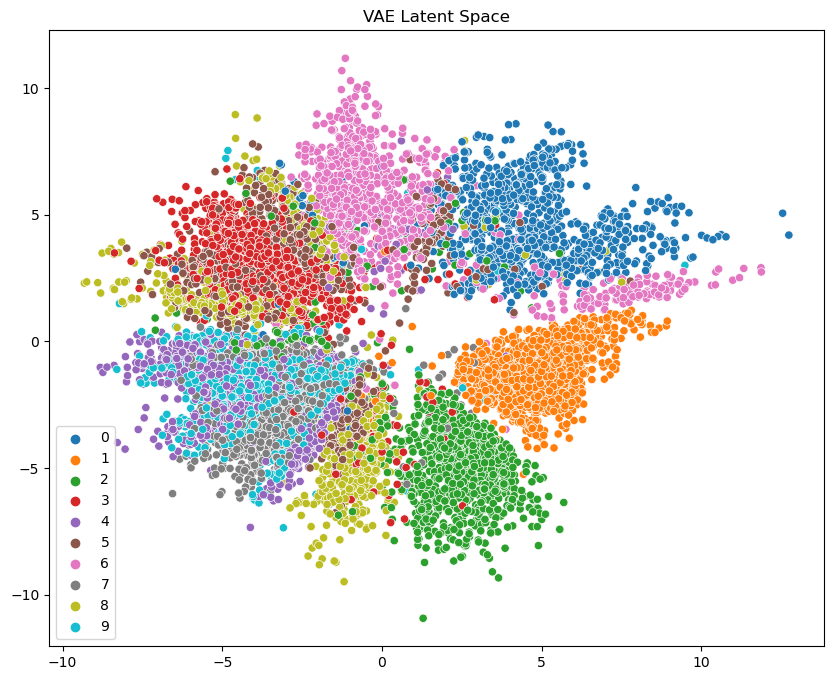

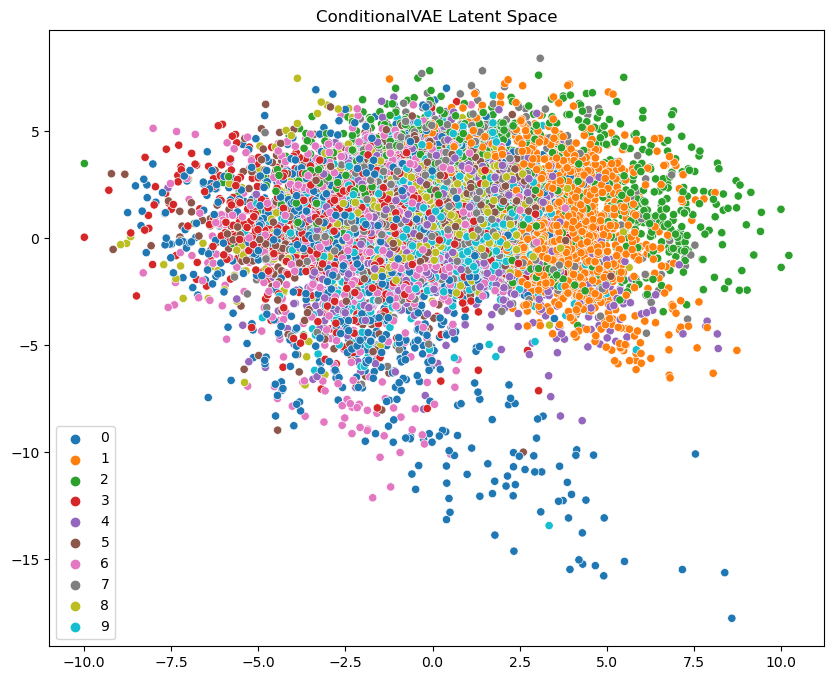

In [8]:
def plot_latent_space(model, dataloader, conditional=False):
    latent_vars = []
    labels = []
    for i, data in enumerate(dataloader):
        x, y = data
        x = x.view(x.shape[0], -1)
        if conditional:
            mean, _ = model.enc_to_mean_lss(torch.cat([x, model.label_embedding(y)], dim=1))
        else:
            mean, _ = model.enc_to_mean_lss(x)
        latent_vars.append(mean.detach().numpy())
        labels.append(y.detach().numpy())

    latent_vars = np.concatenate(latent_vars, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=latent_vars[:, 0], y=latent_vars[:, 1], hue=labels, palette='tab10', legend='full')
    plt.title(f"{type(model).__name__} Latent Space")
    plt.show()

# Assuming test_loader is your MNIST test set dataloader
plot_latent_space(vae_instance, test_loader)
plot_latent_space(cvae_instance, test_loader, conditional=True)

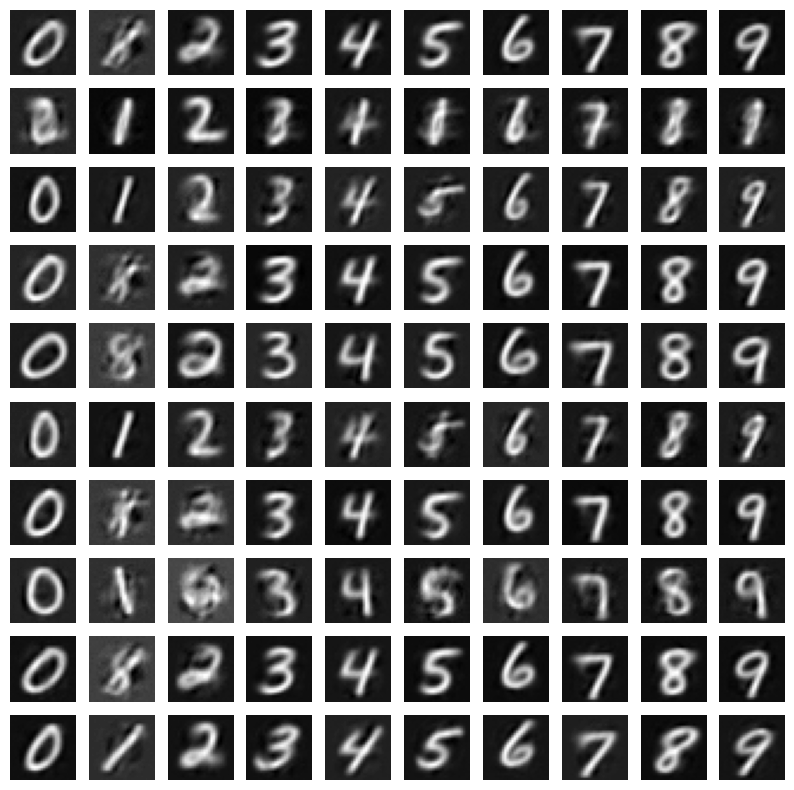

In [9]:
# Add decode method to your ConditionalVAE class
def decode(self, z, condition):
    condition = self.label_embedding(condition)
    z_conditioned = torch.cat([z, condition], dim=1)
    return self.dec(z_conditioned)

# Update ConditionalVAE with new method
ConditionalVAE.decode = decode

# Load the first 10 data points from test_loader
first_10_data_points, first_10_labels = next(iter(DataLoader(test_loader.dataset, batch_size=10, shuffle=False)))

# Reshape and encode the data points
first_10_data_points = first_10_data_points.view(first_10_data_points.shape[0], -1)
mean, _ = cvae_instance.enc_to_mean_lss(torch.cat([first_10_data_points, cvae_instance.label_embedding(first_10_labels)], dim=1))

# Create a figure to plot 100 digits (10 rows of 10 digits each)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))

# Loop over each of the first 10 data points
for i, latent_var in enumerate(mean):
    # Loop over each class (0 to 9)
    for j in range(10):
        condition = torch.tensor([j])
        # Decode and reshape the image
        decoded_image = cvae_instance.decode(latent_var.unsqueeze(0), condition).detach().numpy().reshape(28, 28)
        axes[i, j].imshow(decoded_image, cmap='gray')
        axes[i, j].axis('off')

plt.show()

# Question 2

Similarity (MSE) between z0 and z1: 0.1009407490491867


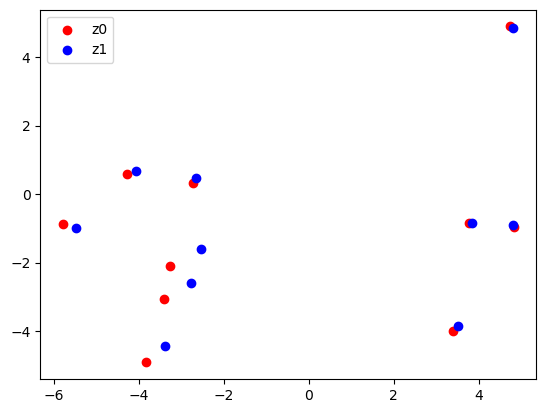

In [10]:
# Load a batch of test data
test_batch = next(iter(test_loader))
test_images, _ = test_batch
test_images = test_images.view(test_images.shape[0], -1)

# Get z0 and x1
with torch.no_grad():
    z0 = vae_instance.encode_mean(test_images)
    x1 = vae_instance.decode(z0)

# Get z1
with torch.no_grad():
    z1 = vae_instance.encode_mean(x1)

# Calculate similarity
mse_loss_func = torch.nn.MSELoss()
similarity = mse_loss_func(z0, z1)
print(f"Similarity (MSE) between z0 and z1: {similarity.item()}")

# Optional: Visualize z0 and z1
z0_np = z0.cpu().numpy()
z1_np = z1.cpu().numpy()
plt.figure()
plt.scatter(z0_np[:, 0], z0_np[:, 1], c='r', label='z0')
plt.scatter(z1_np[:, 0], z1_np[:, 1], c='b', label='z1')
plt.legend()
plt.show()
